In [1]:
import pandas as pd 
import seaborn as sns
import os
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB


In [185]:
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import precision_score


In [2]:
pd.set_option('display.max_columns', None)


NameError: name 'pd' is not defined

In [3]:
print(os.getcwd())

/Users/matheus/Projects/steam_analysis/steam-analysis/notebooks/modeling


In [4]:
os.chdir('../../')

In [191]:
data = pd.read_csv('data/interim/steam-transformed-data.csv')

In [192]:
data = data[data['year']>=2023]

In [193]:
data['random_noise'] = np.random.randn(len(data))

In [ ]:
X["random_cat"] = rng.randint(3, size=X.shape[0])
X["random_num"] = rng.randn(X.shape[0])

In [194]:
X = data[['Achievements', 'about_length',
       'n_screens', 'n_movies', 'n_tags', 'n_languages', 'has_publisher',
       'perceived_quality', 'has_support_email', 'has_support_url', 'has_website', 'random_noise']]
y = data['success_500_threshold']

In [195]:
# First split: Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [213]:

# # Replace 'target' with the name of your target variable
# from lightgbm import LGBMClassifier
# X = data[['Achievements', 'about_length',
#        'n_screens', 'n_movies', 'n_tags', 'n_languages', 'has_publisher',
#        'perceived_quality', 'has_support_email', 'has_support_url', 'has_website', 'month', 'day',
#        'year', 'random_noise']]
# y = data['success_500_threshold']

# # Split the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=10000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Support Vector Machine': SVC(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'LightGBM' : LGBMClassifier()
}

# Function to evaluate classifiers
def evaluate_classifier(clf, X, y, cv_splits=5):
    # cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)
    
    # Scoring for precision
    scoring = make_scorer(precision_score, average='binary', zero_division=0)
    
    # Calculate cross-validated scores for precision
    precision_scores = cross_val_score(clf, X, y, cv=cv_splits, scoring=scoring)
    mean_precision = np.mean(precision_scores)
    
    return precision_scores

In [214]:
results = {}
for clf_name, clf in classifiers.items():
    precision= evaluate_classifier(clf, X_train, y_train)
    results[clf_name] = {
        'Precision': precision,
    }


[LightGBM] [Info] Number of positive: 184, number of negative: 8848
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 978
[LightGBM] [Info] Number of data points in the train set: 9032, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020372 -> initscore=-3.873011
[LightGBM] [Info] Start training from score -3.873011
[LightGBM] [Info] Number of positive: 183, number of negative: 8849
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000728 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 982
[LightGBM] [Info] Number of data points in the train set: 9032, number of used features: 12
[LightGBM] [Info] [binary:Bo

In [199]:
def plot_precision_boxplot(results):
    model_names = []
    precision_scores_list = []

    # Extract model names and their respective precision scores
    for model_name, metrics in results.items():
        model_names.append(model_name)
        precision_scores_list.append(metrics['Precision'])

    # Create the boxplot
    fig, ax = plt.subplots()
    ax.boxplot(precision_scores_list, labels=model_names, vert=True, patch_artist=True)
    
    ax.set_xlabel('Models')
    ax.set_ylabel('Precision Scores')
    ax.set_title('Model Comparison - Precision (Boxplot)')
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

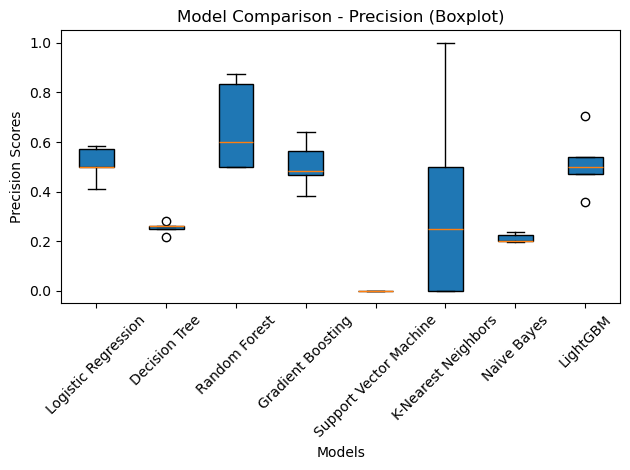

In [215]:
plot_precision_boxplot(results)

In [217]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Instantiate Random Forest classifier
rf = RandomForestClassifier()

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring=make_scorer(precision_score, average='binary', zero_division=0))

# Perform grid search
grid_search.fit(X_test, y_test)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_precision = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Precision:", best_precision)


Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 10}
Best Precision: 0.7666666666666666


In [219]:
rf = RandomForestClassifier(max_depth= 10, min_samples_leaf= 2, min_samples_split=5, n_estimators=10)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=10)

In [206]:
y_pred = rf.predict(X_test)
score = precision_score(y_test, y_pred)

In [220]:
score

0.7857142857142857

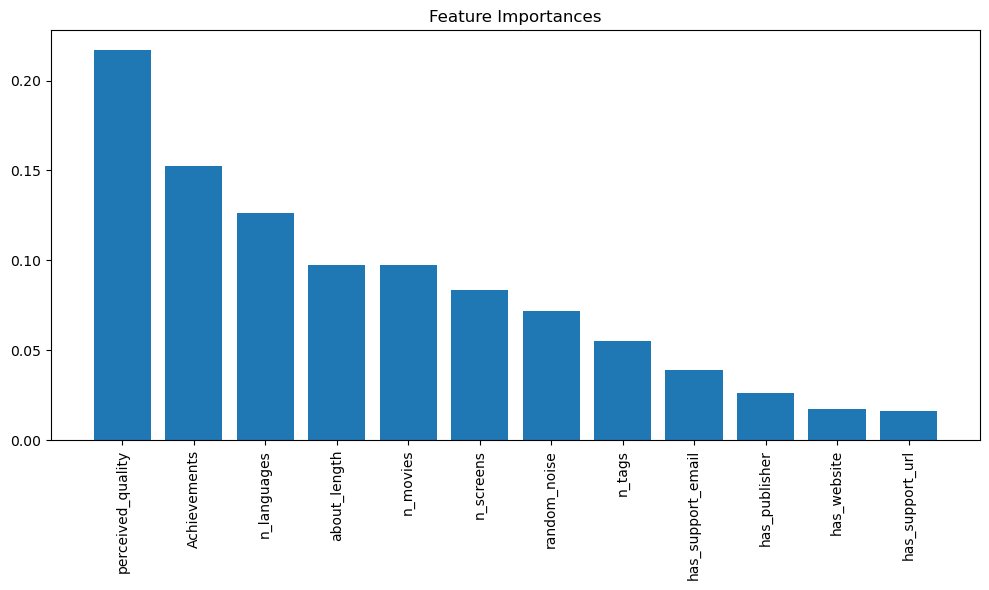

In [221]:

# Retrieve feature importances
importances = rf.feature_importances_

# Get feature names
feature_names = X.columns

# Sort feature importances in descending order
indices = importances.argsort()[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


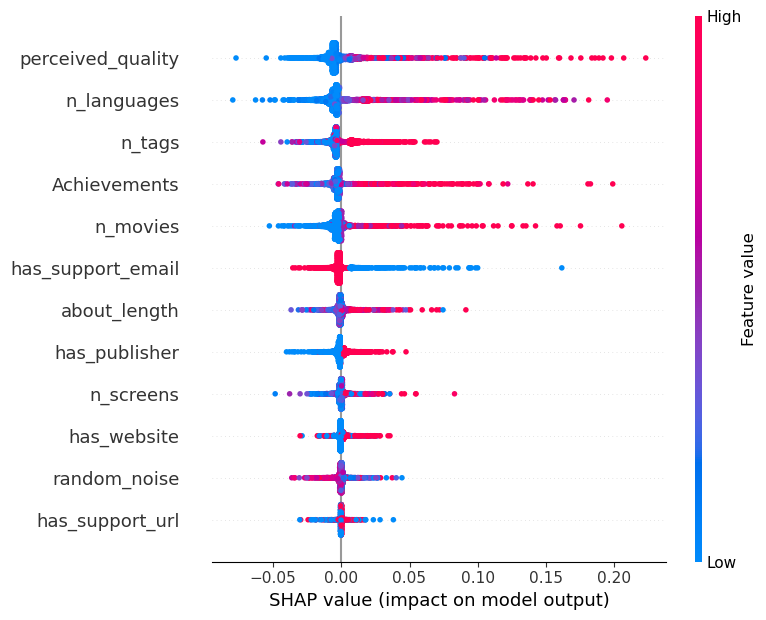

In [222]:
import shap

# Initialize SHAP explainer
explainer = shap.TreeExplainer(rf)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Plot summary of SHAP values for the test set
shap.summary_plot(shap_values[1], X_test)  

In [62]:
from sklearn.inspection import permutation_importance


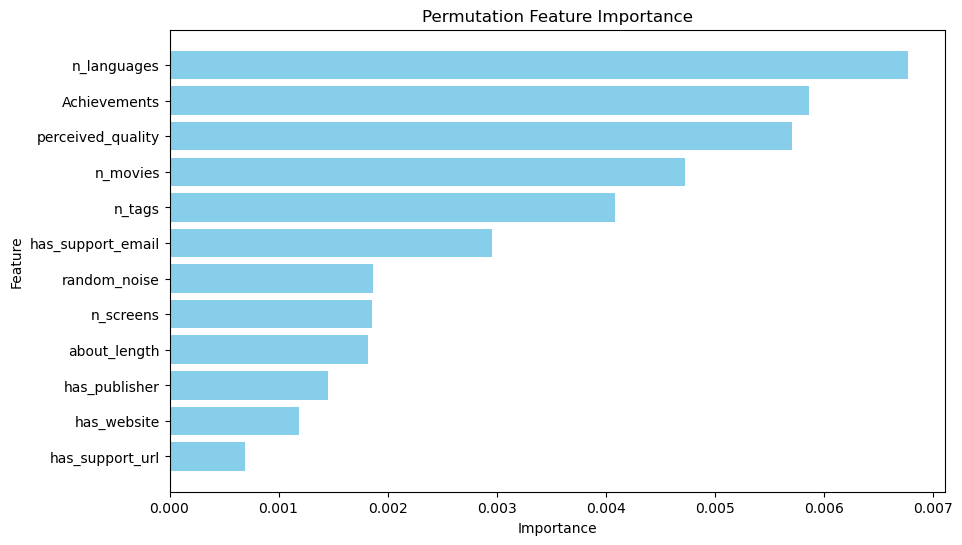

In [231]:
# Compute permutation feature importance
result = permutation_importance(rf, X_train, y_train, n_repeats=30, random_state=42, n_jobs=-1)

# Get feature importances and their corresponding indices
feature_importances = result.importances_mean
features = X.columns

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Permutation Feature Importance')
plt.gca().invert_yaxis()
plt.show()

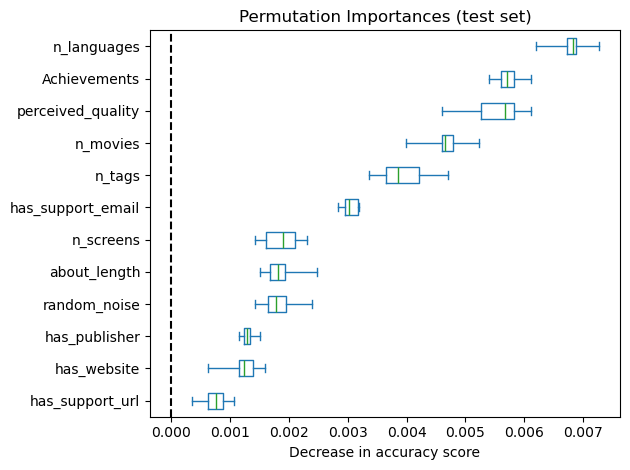

In [233]:
result = permutation_importance(
    rf, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()